# Benchmark Kriging

In this tutorial, we will learn how to validate our Kriging model. We'll compare it to the **Inverse Distance Weighting** function, where the unknown point value is interpolated as the weighted mean of its neighbors. Weights are inversely proportional to the distance between neighboring points, decreasing faster when we raise denominator to the higher number.

## Prerequisites

- **Domain**:
  - semivariance and covariance functions
  - kriging (basics)
- **Package**:
  - `TheoreticalVariogram`
  - `ExperimentalVariogram`
  - `ordinary_kriging()`
- **Programming**:
  - Python basics
  - `pandas` basics

## Table of contents

1. Introduction - IDW as benchmarking tool.
2. Perform IDW and validate outputs.
3. Perform Kriging and validate outputs.


## 1. Introduction - IDW as bechmarking tool

(1) **General Form of Inverse Distance Weighting**

$$z(u)=\frac{\sum_{i}{(\lambda_{i} * z_{i})}}{\sum_{i}{\lambda{i}}}$$

where:

- $z(u)$: predicted value
- $i$: i-th known location
- $z_{i}$: value at known location $i$
- $\lambda_{i}$: weight assigned to the point in known location $i$

(2) **Weighting Parameter**

$$\lambda_{i}=\frac{1}{d_{i}^{p}}$$

where:

- $d$: is a distance from the known point $z_{i}$ to the unknown point $z(u)$
- $p$: is a hyperparameter that controls correlation between a known and unknown point. Greater $p$ means that the influence of the closest neighbors is extremely high, but it quickly diminishes with a distance. On the other hand, you may set a small $p$ to emphasize that even distant neighbors are influencing the unknown location.

---

**IDW** is a simple yet powerful technique. Unfortunately, it has a significant drawback: we must set $p$ - power - manually, and it is constant across all distances. That's why Kriging - in most cases - performs much better than IDW, weights are related to the distance to a neighbor, and are estimated when we build semivariogram model.


In [9]:
import geopandas as gpd
import numpy as np
import pandas as pd

from tqdm import tqdm

from pyinterpolate import inverse_distance_weighting
from pyinterpolate import build_experimental_variogram, build_theoretical_variogram
from pyinterpolate import ordinary_kriging

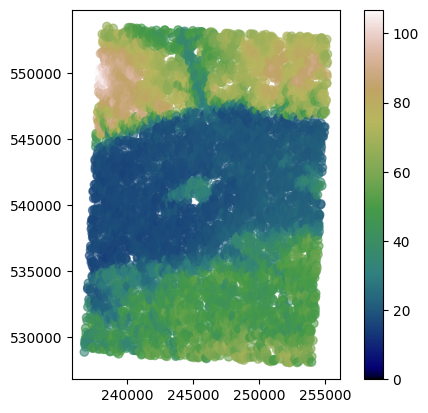

In [2]:
# Load DEM data

df = pd.read_csv(
    '../data/dem.csv'
)
# Populate geometry column and set CRS

dem_geometry = gpd.points_from_xy(x=df['longitude'], y=df['latitude'], crs='epsg:4326')
dem = gpd.GeoDataFrame(df, geometry=dem_geometry)

# Transform crs to metric values
dem.to_crs(epsg=2180, inplace=True)
dem.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True);

In [3]:
step_size = 500  # meters
max_range = 10000  # meters

In [4]:
train = dem.sample(n=int(0.02*len(dem)))
test = dem.loc[~dem.index.isin(train.index)]

In [5]:
print(len(train), len(test))

137 6758


<Axes: >

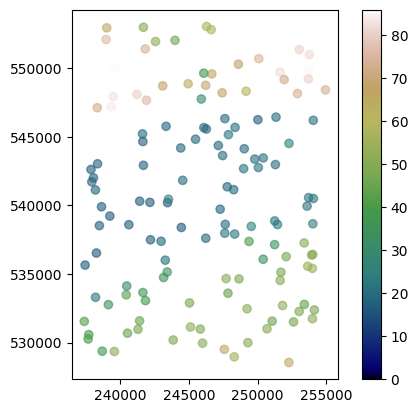

In [6]:
train.plot(column='dem', cmap='gist_earth', alpha=0.6, vmin=0, legend=True)

## 2. Perform IDW and validate outputs

Inverse Distance Weighting doesn't require variogram modeling. We pass the `power` parameter that affects weighting". Things to remember are:"

- large `power` value -> closer neighbors are more important
- `power` which is close to the zero -> all neighbors are important, and we assume that the distant process has the same effect on our variable as the closest neighbors

In [7]:
idw_power = 2
number_of_neighbors = 8

idw_preds = test['geometry'].apply(
            lambda loc: inverse_distance_weighting(
                train[['geometry', 'dem']],
                unknown_location=(loc.x, loc.y),
                no_neighbors=number_of_neighbors,
                power=idw_power
            )
        )

In [8]:
idw_rmse = np.mean(
    np.sqrt(
        (test['dem'] - idw_preds)**2
    )
)

print(f'Root Mean Squared Error of prediction with IDW is {idw_rmse}')

Root Mean Squared Error of prediction with IDW is 4.26318444803915


**Clarification**: Obtained Root Mean Squared Error could serve as a baseline for further model development. To build a better reference, we create four IDW models of powers:

1. `0.5`
2. `1`
3. `2`
4. `4`

In [10]:
IDW_POWERS = [0.5, 1, 4]  # we have 2 already
idws = {
    2: idw_rmse
}

for pw in tqdm(IDW_POWERS):
    idw_preds = test['geometry'].apply(
            lambda loc: inverse_distance_weighting(
                train[['geometry', 'dem']],
                unknown_location=(loc.x, loc.y),
                no_neighbors=number_of_neighbors,
                power=pw
            )
        )
    idw_rmse = np.mean(
        np.sqrt(
            (test['dem'] - idw_preds)**2
        )
    )
    idws[pw] = idw_rmse

100%|██████████| 3/3 [00:43<00:00, 14.56s/it]


In [13]:
for pw, val in idws.items():
    print(f'Root Mean Squared Error of prediction with IDW of power {pw} is {val:.4f}')

Root Mean Squared Error of prediction with IDW of power 2 is 4.2632
Root Mean Squared Error of prediction with IDW of power 0.5 is 5.3416
Root Mean Squared Error of prediction with IDW of power 1 is 4.8539
Root Mean Squared Error of prediction with IDW of power 4 is 4.0798


## 3. Perform Kriging and validate outputs

Now, we are going to compare IDW results to Kriging output.

In [14]:
exp_var = build_experimental_variogram(
    ds=train[['geometry', 'dem']],
    step_size=step_size,
    max_range=max_range
)

In [15]:
theo_var = build_theoretical_variogram(
    experimental_variogram=exp_var,
    models_group='linear'
)

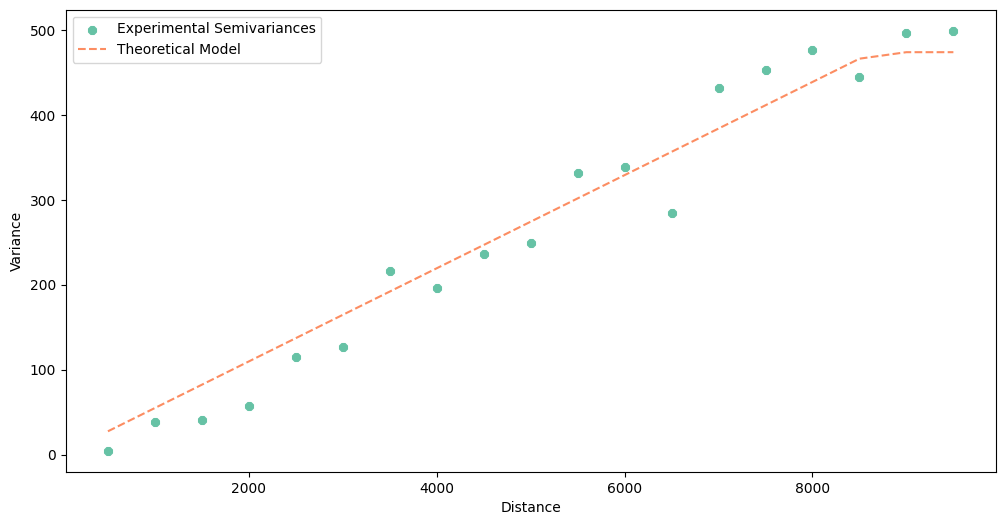

In [16]:
theo_var.plot()

In [17]:
kriging_preds = test['geometry'].apply(
            lambda loc: ordinary_kriging(
                theoretical_model=theo_var,
                known_locations=train[['geometry', 'dem']],
                unknown_location=(loc.x, loc.y),
                no_neighbors=number_of_neighbors,
                allow_approximate_solutions=False
            )[0]
        )

In [18]:
kriging_rmse = np.mean(
    np.sqrt(
        (test['dem'] - kriging_preds)**2
    )
)

In [19]:
print(f'Root Mean Squared Error of prediction with Kriging is {kriging_rmse}')

Root Mean Squared Error of prediction with Kriging is 4.164396486557602


Your results may be different (if your train and test sets are divided in a different way), but in most cases, Kriging will be better than IDW or very close to the best results from IDW. Even more important is that for the single data source with a low number of samples, we don't have the opportunity to perform the validation step, and we're unable to guess how big the power parameter should be. With Kriging, we model variogram, and *voila!* - model works.

## Changelog

| Date       | Changes                                      | Author                           |
|------------|----------------------------------------------|----------------------------------|
| 2025-05-02 | Tutorial has been adapted to the 1.0 release | @SimonMolinsky (Szymon Moliński) |